In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
from glob import glob
import re
import pylab as pl

In [6]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
#clrs = sns.color_palette("Spectral", as_cmap=True)
#colors = cycler('color', list(clrs.as_hex()))
plt.rc('font', family='serif')
mpl.rc('text', usetex=True)
#mpl.rcParams['text.latex.preamble'] = r'\boldmath'

plt.rc('axes', axisbelow=True, 
       grid=False)#, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
#plt.rc('font', **font)

# Runtime comparison between swift zoom and arepo

In [12]:
from unyt import ms, hour
def get_timesteps(timesteps_file):
    f = np.genfromtxt(timesteps_file, usecols=(2,12), invalid_raise = False)

    a = f[:,0] # Scale-factor
    t = f[:,1] #* ms # Wallclock time
    return a, t

filename = "/cosma7/data/dp004/dc-kott1/swift/vol03_lp1_results/timesteps_112.txt"
filename2 = "/cosma7/data/dp004/dc-kott1/swift/vol03_m5_zoom_1node/timesteps_28.txt"
a, swift_t_base = get_timesteps(filename)
swift_t = swift_t_base * ms
swift_t = np.cumsum(swift_t).to(hour)

a2, swift_t_base2 = get_timesteps(filename2)
swift_t2 = swift_t_base2 * ms
swift_t2 = np.cumsum(swift_t2).to(hour)
#arepo
arepo_df = pd.read_csv("/cosma7/data/dp004/dc-kott1/arepo_results/vol03_lp1_512mesh/output/wallclock.txt", delimiter='\t', index_col = 0)
arepo_t = arepo_df['Wallclock']/3600

In [ ]:
plt.figure(dpi = 200, figsize=(5,4))
#plt.plot(arepo_df['Time'], arepo_t, label='Arepo')
plt.plot(a, swift_t, label = 'SWIFT zoom-in branch')
plt.plot(a2, swift_t2, label = 'SWIFT main branch')
plt.ylabel('Wallclock time (hr)')
plt.xlabel('Scale factor')
plt.legend()
plt.suptitle('SWIFT vs Arepo runtime')
plt.title(r'Resolution: $10^4 M_{\odot}$; No. CPUs: 112; Volume: $5 Mpc$', fontsize='small', fontweight='light')
plt.savefig('plots/swift_runtimeplot.pdf')

# Analyse tasks

## Arepo

In [6]:
data = []
#This code was generated with the help of ChatGPT, due to the complexity of the text file
with open('/cosma7/data/dp004/dc-kott1/arepo_results/vol03_lp1_512mesh/output/cpu.txt', 'r') as file:
    for line in file:
        if line.startswith('Step'):
            step_info = line.split(',')
            step_number = int(step_info[0].split()[1])
            time = float(step_info[1].split(':')[1])
            #cpus = int(step_info[2].split(':')[1])
            multi_domains = int(step_info[3].split(':')[1])
            highest_active_time_bin = int(step_info[4].split(':')[1])
            # Append the parsed data as a dictionary to the 'data' list
            data.append({
                'Step': step_number,
                'Time': time,
                #'CPUs': cpus,
                'MultiDomains': multi_domains,
                'HighestActiveTimeBin': highest_active_time_bin,
                'Details': []
            })
        elif line.strip() and not line.strip().startswith('diff'):  # Check if the line is not empty and does not start with 'diff' or 'total'
            # Extract detailed information from the line
            parts = line.split()
            name = ' '.join(parts[:-4])  # Join all parts except the last three
            diff_perc = parts[-3] if '%' not in parts[-3] else float(parts[-3].replace('%', ''))
            diff = parts[-4]
            cumulative_perc = parts[-1] if '%' not in parts[-1] else float(parts[-1].replace('%', ''))
            cumulative = parts[-2]
            
            diff = float(diff)
            cumulative = float(cumulative)
            
            # Append the detailed information as a dictionary to the 'Details' list of the last element in 'data'
            data[-1]['Details'].append({
                'Name': name,
                'Diff': diff,
                'Diff%': diff_perc,
                'Cumulative': cumulative,
                'Cumulative%': cumulative_perc
            })

In [7]:
df = pd.DataFrame(data)
df.set_index('Step', inplace = True)
df['Details'].iloc[0]

[{'Name': 'total',
  'Diff': 597.37,
  'Diff%': 100.0,
  'Cumulative': 597.37,
  'Cumulative%': 100.0},
 {'Name': 'treegrav',
  'Diff': 474.74,
  'Diff%': 79.5,
  'Cumulative': 474.74,
  'Cumulative%': 79.5},
 {'Name': 'treebuild',
  'Diff': 2.92,
  'Diff%': 0.5,
  'Cumulative': 2.92,
  'Cumulative%': 0.5},
 {'Name': 'insert',
  'Diff': 1.72,
  'Diff%': 0.3,
  'Cumulative': 1.72,
  'Cumulative%': 0.3},
 {'Name': 'branches',
  'Diff': 0.75,
  'Diff%': 0.1,
  'Cumulative': 0.75,
  'Cumulative%': 0.1},
 {'Name': 'toplevel',
  'Diff': 0.0,
  'Diff%': 0.0,
  'Cumulative': 0.0,
  'Cumulative%': 0.0},
 {'Name': 'treecostm',
  'Diff': 0.69,
  'Diff%': 0.1,
  'Cumulative': 0.69,
  'Cumulative%': 0.1},
 {'Name': 'treewalk',
  'Diff': 268.29,
  'Diff%': 44.9,
  'Cumulative': 268.29,
  'Cumulative%': 44.9},
 {'Name': 'treewalk1',
  'Diff': 169.77,
  'Diff%': 28.4,
  'Cumulative': 169.77,
  'Cumulative%': 28.4},
 {'Name': 'treewalk2',
  'Diff': 98.52,
  'Diff%': 16.5,
  'Cumulative': 98.52,
  'Cumu

### How much time does each sub calculation take in comparison to the total?

In [8]:
#This code was 
top_names = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Filter out the rows with the name "total"
    filtered_details = [detail for detail in row['Details'] if detail['Name'] != 'restart']
    if filtered_details:
        # Sort the filtered "Details" based on "Diff" in descending order
        sorted_details = sorted(filtered_details, key=lambda x: x['Diff'], reverse=True)
        # Select the top 5 names based on "Diff"
        top_5_details = sorted_details[:3]
        # Append the top 5 names to the results list
        for detail in top_5_details:
            top_names.append((index, detail['Name'], detail['Diff']))

# Convert the results to a DataFrame
top_names_df = pd.DataFrame(top_names, columns=['Step', 'Name', 'Diff'])

top_names_df['Name'].unique()

array(['total', 'treegrav', 'treewalk', 'domain', 'peano', 'fof',
       'treeimbal', 'subfind', 'misc'], dtype=object)

In [9]:
unique_top_names = ['total', 'treegrav', 'treewalk', 'domain', 'treeimbal']

top_values_dict = {name: {'Step': [], 'Cumulative': [], 'Cumulative%': []} for name in unique_top_names}

for step in df.index:
    for name in unique_top_names:
        detail = next((detail for detail in df.at[step, 'Details'] if detail['Name'] == name), None)
        if detail:
            top_values_dict[name]['Step'].append(step)
            top_values_dict[name]['Cumulative'].append(detail['Cumulative'])
            top_values_dict[name]['Cumulative%'].append(detail['Cumulative%'])

top_values_dfs = {name: pd.DataFrame(data) for name, data in top_values_dict.items()}

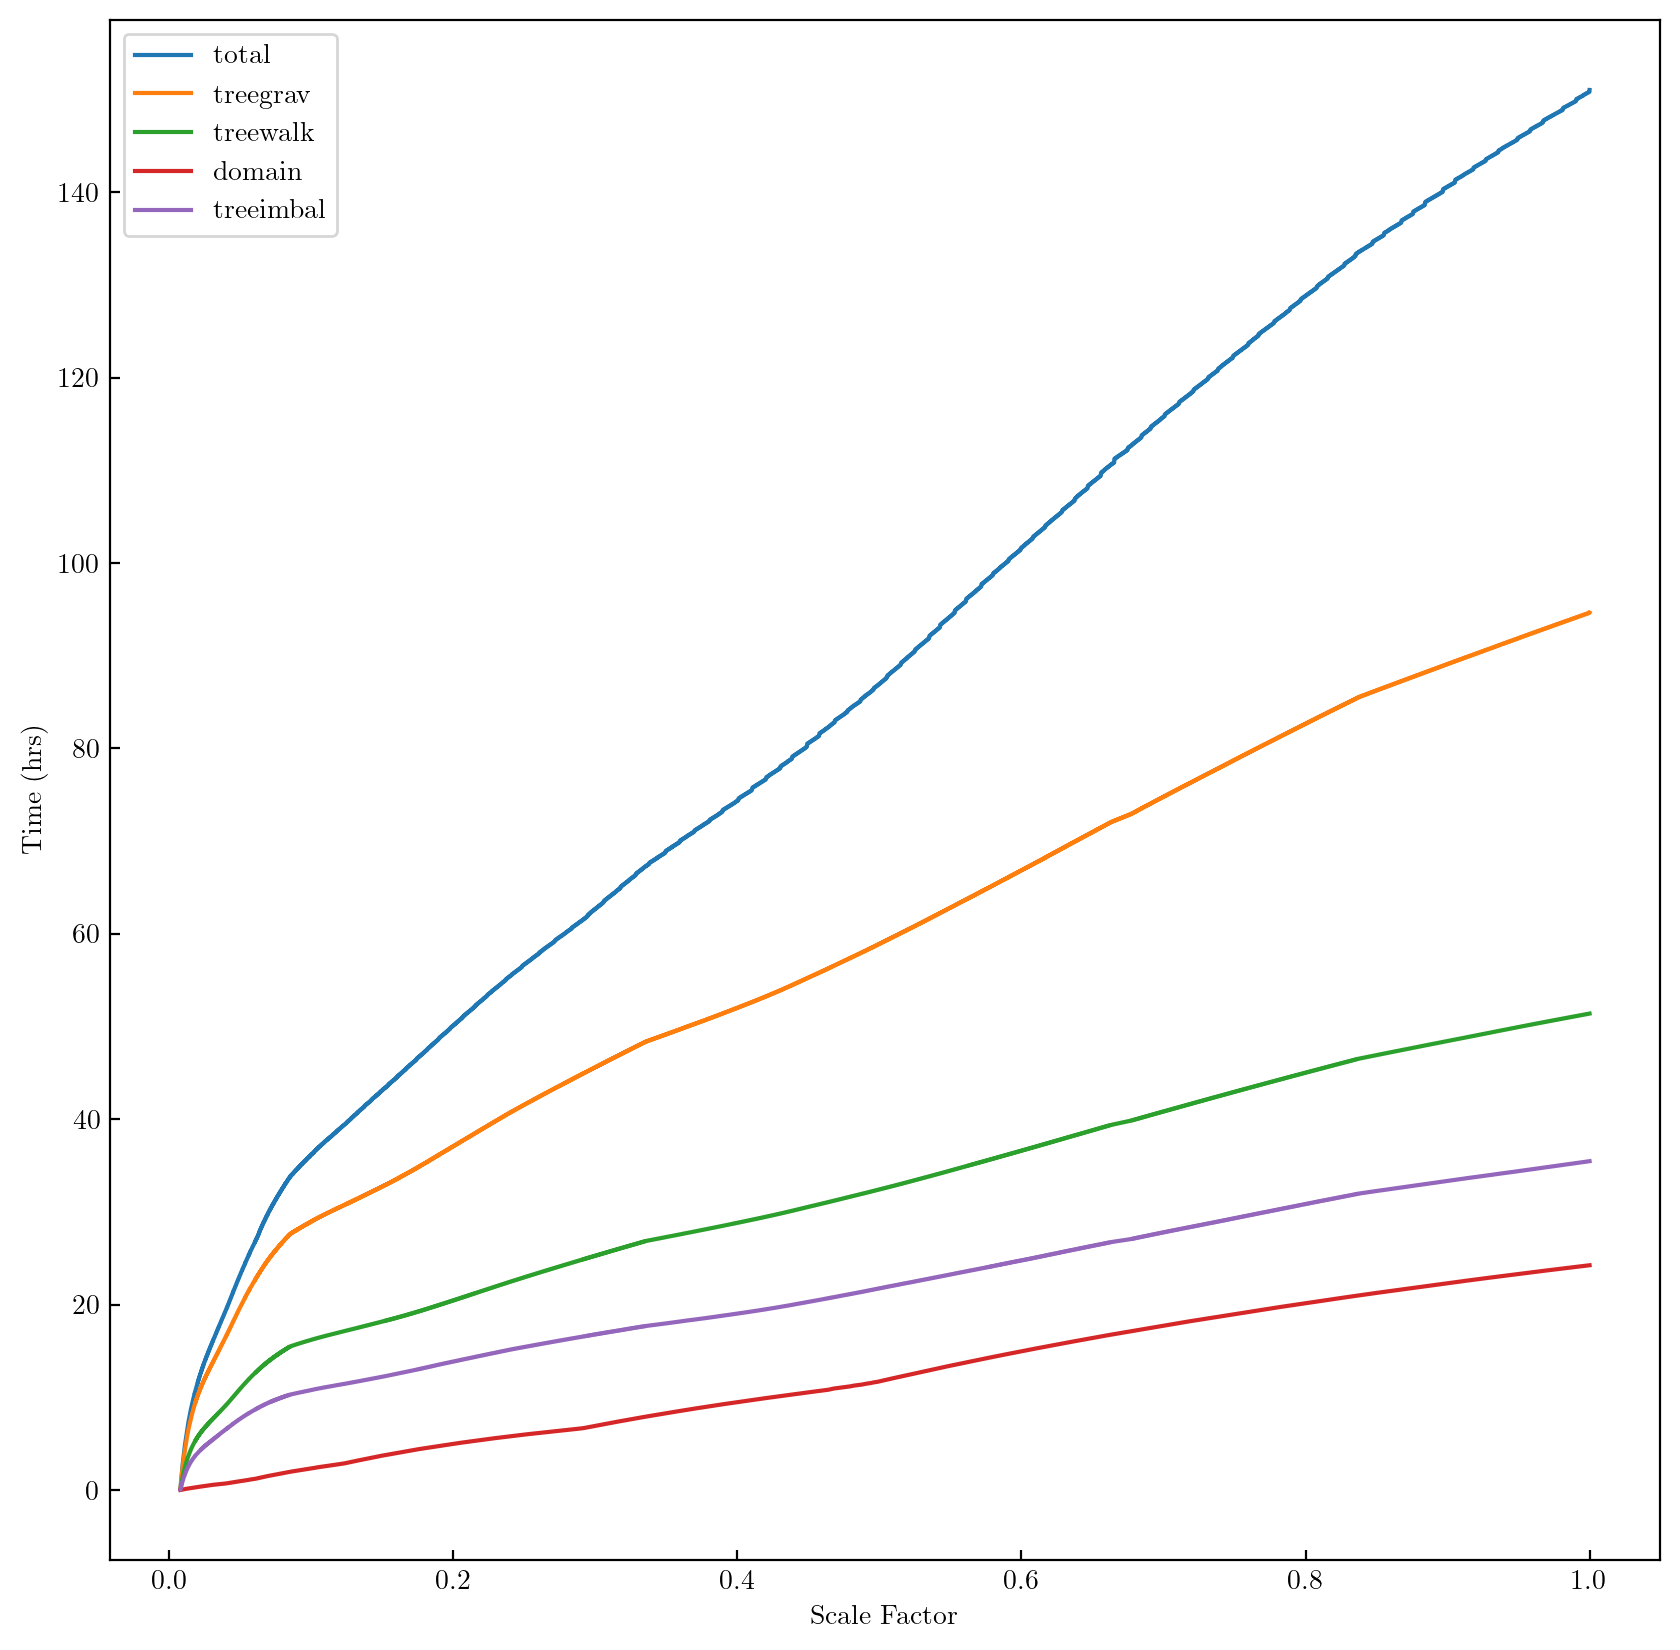

In [10]:
plt.figure(figsize = (10,10), dpi = 200)
#plt.plot(df.index.values, df['Time'], label='total')
for name, top_df in top_values_dfs.items():
    plt.plot(np.array(df['Time'])[np.array(top_values_dfs.get('total')['Step'])], top_df['Cumulative']/3600, label=name)
plt.xlabel('Scale Factor')
plt.ylabel('Time (hrs)')
plt.legend()
#plt.xlim(550,600)
plt.savefig('plots/arepo_task_times.pdf')
plt.show()

# SWIFT Task analysis

In [11]:
#analysis tools paths
python_plot_tools_path = "/cosma/home/dp004/dc-kott1/swiftsim/tools/task_plots/"
analyse_tasks = os.path.join(python_plot_tools_path, "analyse_tasks.py")
plot_tasks = os.path.join(python_plot_tools_path, "plot_tasks.py")
plot_task_dependencies = os.path.join(python_plot_tools_path, "plot_tasks_dependencies.py")

#thread tasks data tables
thread_dat_files = sorted(glob("/cosma/home/dp004/dc-kott1/swift_thread_files/thread_stats-step*.dat"))

In [12]:
ex_data = np.loadtxt(thread_dat_files[0], dtype=str, skiprows=1)
column_names = ['task', 'ntasks', 'min', 'max', 'sum', 'mean', 'percent', 'mintic', 'maxtic', 'meantic', 'fixed_cost']
# Remove the first row (column names) from the data array
swift_df = pd.DataFrame(ex_data,  columns = column_names)
swift_df[swift_df.columns[1:]] = swift_df[swift_df.columns[1:]].astype(float)
top_tasks_swift = list(swift_df.sort_values(by='percent', ascending=False)['task'])
#swift_df
print(top_tasks_swift)

['pair/grav_zoombkg', 'pair/grav_bkg', 'grav_mm/none', 'self/grav_bkg', 'pair/grav', 'self/grav', 'init_grav/none', 'drift_gpart_bkg/none', 'grav_down/none', 'timestep/none', 'drift_gpart/none', 'kick2/none', 'kick1/none', 'grav_long_range/none', 'grav_end_force/none', 'grav_long_range_bkg/none', 'collect/none']


In [13]:
cpu_clock = pl.loadtxt('/cosma/home/dp004/dc-kott1/swift_thread_files/thread_info-step1002.dat')[0,:][-5]/1000
print(cpu_clock)

2194832.63


In [14]:
top_tasks_swift = ['pair/grav_zoombkg', 'pair/grav_bkg', 'grav_mm/none', 'self/grav_bkg', 'pair/grav', 'self/grav', 'timestep/none']
swift_info = {name: {'step': [], 'ntasks': [], 'cputime': [], 'percent': []} for name in top_tasks_swift}

for file in thread_dat_files:
    pattern = r'step(\d+)'
    match = re.search(pattern, file)
    if match:
        step_num = int(match.group(1))
    
    data = np.loadtxt(file, dtype=str, skiprows=1)
    column_names = ['task', 'ntasks', 'min', 'max', 'sum', 'mean', 'percent', 'mintic', 'maxtic', 'meantic', 'fixed_cost']
    thread_df = pd.DataFrame(data, columns=column_names)
    numeric_cols = column_names[1:]
    thread_df[numeric_cols] = thread_df[numeric_cols].astype(float)
    thread_df['cputime'] = abs(thread_df['maxtic'] - thread_df['mintic'])

    for task in top_tasks_swift:
        task_df = thread_df[thread_df['task'] == task]
        if not task_df.empty:
            swift_info[task]['step'].append(step_num)
            swift_info[task]['ntasks'].append(int(task_df['ntasks'].iloc[0]))
            swift_info[task]['cputime'].append(float(task_df['cputime'].iloc[0]))
            swift_info[task]['percent'].append(float(task_df['percent'].iloc[0]))
        else:
            swift_info[task]['step'].append(step_num)
            swift_info[task]['ntasks'].append(0)
            swift_info[task]['cputime'].append(0)
            swift_info[task]['percent'].append(0)

for name in swift_info:
    sorted_indices = np.argsort(swift_info[name]['step'])
    swift_info[name] = {key: [value[i] for i in sorted_indices] for key, value in swift_info[name].items()}

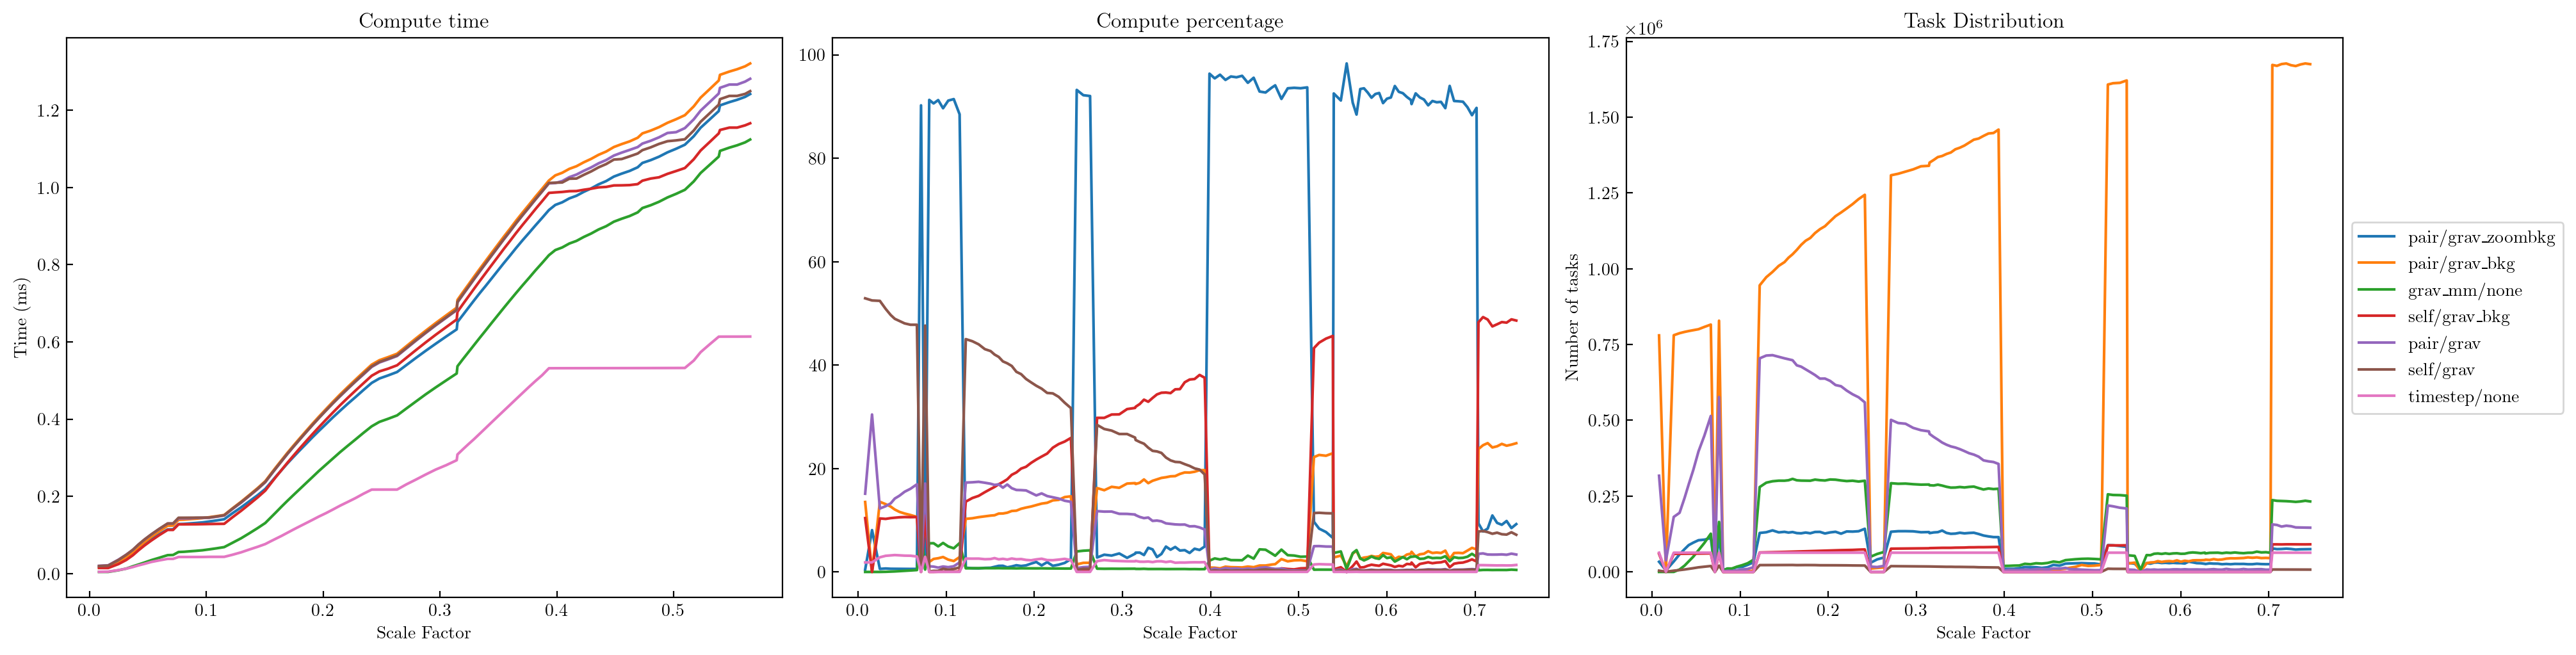

In [16]:
scale_factors = a[swift_info['pair/grav_zoombkg']['step']]
fig, ax = plt.subplots(1, 3, figsize=(20,5), dpi=200, constrained_layout=True)
for name, top_df in swift_info.items():
    cumulative_cputime = np.cumsum(top_df['cputime'])/cpu_clock  # CPU ticks as per the original code
    percent = top_df['percent']
    ntasks = top_df['ntasks']
    ax[0].plot(scale_factors[:92], cumulative_cputime[:92], label=name)
    ax[0].set_ylabel('Time (ms)')
    ax[0].set_title('Compute time')
    ax[1].plot(scale_factors, percent, label=name)
    ax[1].set_ylabel('% of tasks')
    ax[1].set_title('Compute percentage') #what actually is this?
    ax[2].plot(scale_factors, ntasks, label=name)
    ax[2].set_ylabel('Number of tasks')
    ax[2].set_title('Task Distribution')
    
for plot in ax:
    plot.set_xlabel('Scale Factor')

ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
fig.show()

plt.savefig('plots/swift_task_plot.png')
#time is an approximation since each rank has different cpu clock speed. these aren't very different from each other